# Data Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import Data

In [6]:
import os
import datetime as dt

main_path = os.getcwd()

#load price (exchange rate) data
df_P = pd.read_pickle(main_path+'/data/future_price_use.pkl')
df_P = df_P.fillna(method='ffill').drop(df_P.index[0])

#weekly return
df_r = pd.read_pickle(main_path+'/data/future_return_use.pkl')
df_r = df_r.fillna(method='ffill').dropna()
df_r = df_r.drop(columns='ZT')
df_r = df_r.drop(columns='ZF')
df_r

,GC,ZC,HE,CT,YM,NG
Date,,,,,,
2018-05-07,0.004799,-0.022571,-0.026463,-0.020035,0.024558,0.035042
2018-05-14,-0.021835,0.032713,0.143951,0.022808,-0.004109,0.014612
2018-05-21,0.010154,0.008696,-0.006693,0.030734,0.000364,0.032315
2018-05-28,-0.006522,-0.035714,0.045822,0.045847,-0.004084,0.007826
2018-06-04,0.002549,-0.035121,0.029317,0.017578,0.027529,-0.024308
...,...,...,...,...,...,...
2023-03-27,-0.006609,0.027216,-0.024943,0.081526,0.031633,0.000000
2023-04-03,0.021788,-0.025738,-0.014618,0.005074,0.005947,-0.092509
2023-04-10,-0.004821,0.035354,-0.032367,-0.004086,0.011230,0.051218


# Analysis

In [9]:
df_r.GC

Date
2018-05-07    0.004799
2018-05-14   -0.021835
2018-05-21    0.010154
2018-05-28   -0.006522
2018-06-04    0.002549
                ...   
2023-03-27   -0.006609
2023-04-03    0.021788
2023-04-10   -0.004821
2023-04-17   -0.011338
2023-04-24    0.005254
Name: GC, Length: 260, dtype: float64

In [13]:
# Run before Stan
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [31]:
import stan
import numpy as np

model_code = """
data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
}
parameters {
  real mu;                     // mean log volatility
  real<lower=-1, upper=1> phi; // persistence of volatility
  real<lower=0> sigma;         // white noise shock scale
  vector[T] h;                 // log volatility at time t
}
model {
  phi ~ uniform(-1, 1);
  sigma ~ cauchy(0, 5);
  mu ~ cauchy(0, 10);
  h[1] ~ normal(mu, sigma / sqrt(1 - phi * phi));
  for (t in 2:T) {
    h[t] ~ normal(mu + phi * (h[t - 1] -  mu), sigma);
  }
  for (t in 1:T) {
    y[t] ~ normal(0, exp(h[t] / 2));
  }
}
"""

T = len(df_r)
y = df_r.GC.values
data = {'y': y, 'T': T}


stan_model = stan.build(model_code, data=data)

fit = stan_model.sample(num_chains=4, num_samples=1000)


Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2901/8000)
Sampling:  39% (3101/8000)
Sampling:  46% (3701/8000)
Sampling:  61% (4901/8000)
Sampling:  70% (5600/8000)
Sampling:  84% (6700/8000)
Sampling:  89% (7100/8000)
Sampling:  90% (7200/8000)
Samplin

In [34]:
print(fit)

<stan.Fit>
Parameters:
    mu: ()
    phi: ()
    sigma: ()
    h: (260,)
Draws: 4000


In [35]:
samples = fit.to_frame()
mu_samples = samples['mu']
phi_samples = samples['phi']
sigma_samples = samples['sigma']
print(samples.head())

parameters         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                           
0            838.775727       1.000000    0.169237          5.0          31.0   
1            925.169102       0.911274    0.144799          5.0          31.0   
2           1142.224390       0.282961    0.117282          6.0          63.0   
3           1077.419932       0.999081    0.078886          6.0          63.0   
4            820.083110       0.907025    0.169237          5.0          31.0   

parameters  divergent__     energy__        mu       phi     sigma  ...  \
draws                                                               ...   
0                   0.0  -702.655252 -8.027679  0.465671  0.860206  ...   
1                   0.0  -770.881861 -8.302390  0.328150  0.584636  ...   
2                   0.0 -1017.642100 -8.336788  0.925180  0.245503  ...   
3                   0.0  -963.256264 -8.268784  0.874774 

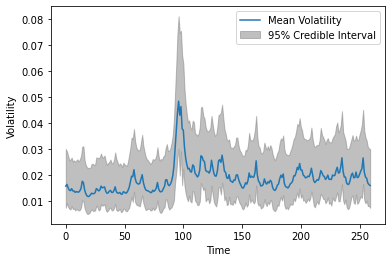

In [36]:
import matplotlib.pyplot as plt

# Extract log-volatility samples from the fit
h_samples = fit["h"]

# Convert log-volatility samples to volatility samples
volatility_samples = np.exp(h_samples / 2)

# Calculate the mean and 95% credible interval of the volatility samples
mean_volatility = np.mean(volatility_samples, axis=1)
lower_volatility = np.percentile(volatility_samples, 2.5, axis=1)
upper_volatility = np.percentile(volatility_samples, 97.5, axis=1)

# Plot the mean volatility
plt.plot(mean_volatility, label="Mean Volatility")

# Plot the 95% credible interval
plt.fill_between(range(len(mean_volatility)),
                 lower_volatility,
                 upper_volatility,
                 color='gray', alpha=0.5, label="95% Credible Interval")

plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [48]:
returns_mean_volatility = norm.rvs(scale=mean_volatility)

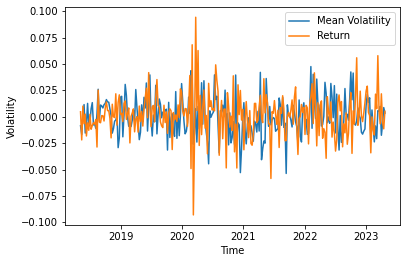

In [49]:
from scipy.stats import norm
plt.plot(df_r.index, returns_mean_volatility, label="Mean Volatility")
plt.plot(df_r.index, df_r.GC.values, label="Return")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

NO MCMC only SV model (For Demo)

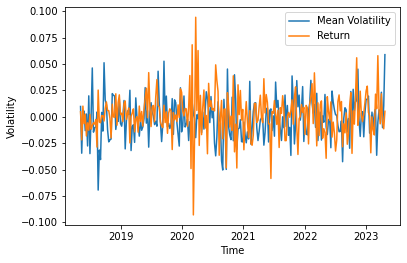

In [64]:
# Initialize an array to store predicted volatilities
predicted_volatilities = np.zeros(T)

# Use the last value of log return as the initial value of volatility
predicted_volatilities[0] = np.log(np.var(y))

# Calculate predicted volatilities for each time point
for t in range(1, T):
    eps = np.random.normal(loc=0, scale=1)
    predicted_volatilities[t] = mu_samples.mean() + phi_samples.mean() * (predicted_volatilities[t-1] - mu_samples.mean()) + sigma_samples.mean() * eps
predicted_volatilities = np.exp(predicted_volatilities/2)
predicted_returns = norm.rvs(scale=predicted_volatilities)
# Plot predicted volatilities
import matplotlib.pyplot as plt

plt.plot(df_r.index, predicted_returns, label="Mean Volatility")
plt.plot(df_r.index, df_r.GC.values, label="Return")
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [50]:
####################### Build Particle Filtering
import numpy as np
from scipy.stats import norm

def particle_filter(y, mu, phi, sigma, N=1000):
    T = len(y)
    log_weights = np.zeros(N)
    particles = np.zeros((T, N))

    # Initialize particles
    particles[0, :] = norm.rvs(loc=mu, scale=sigma / np.sqrt(1 - phi**2), size=N)

    for t in range(1, T):
        # Propagate
        particles[t, :] = mu + phi * (particles[t - 1, :] - mu) + norm.rvs(scale=sigma, size=N)

        # Update weights
        log_weights = -0.5 * (y[t]**2 / np.exp(particles[t, :])) - 0.5 * particles[t, :] - 0.5 * np.log(2 * np.pi)
        log_weights = log_weights - np.max(log_weights)
        weights = np.exp(log_weights)
        weights /= np.sum(weights)

        # Resampling
        idx = np.random.choice(np.arange(N), size=N, p=weights, replace=True)
        particles[t, :] = particles[t, idx]

    return particles

In [51]:
# Retrieve posterior samples
posterior_samples = fit.to_frame()
mu_samples = posterior_samples['mu'].values
phi_samples = posterior_samples['phi'].values
sigma_samples = posterior_samples['sigma'].values

# Perform particle filtering with posterior samples
N = 100 # change to 1000 in the future
particles = np.zeros((len(y), N, len(mu_samples)))

for i, (mu, phi, sigma) in enumerate(zip(mu_samples, phi_samples, sigma_samples)):
    particles[:, :, i] = particle_filter(y, mu, phi, sigma, N=N)

# Calculate filtered volatilities
filtered_volatilities = np.mean(particles, axis=1)

# Convert log-volatility to volatility
volatility_from_filtered_volatilities = np.exp(filtered_volatilities / 2)


In [60]:
mean_corrected_return.shape

(260,)

In [58]:
# Compute the mean and standard deviation of filtered volatilities
mean_filtered_volatilities = np.mean(volatility_from_filtered_volatilities, axis=1)
std_filtered_volatilities = np.std(volatility_from_filtered_volatilities, axis=1)

# mean corrected return y
mean_corrected_return = norm.rvs(scale=mean_filtered_volatilities)

filtered_volatilities 是一个矩阵，其形状为 (时间步数, 后验样本数)，其中每个元素表示对应时间步的过滤波动率。在这个案例中，filtered_volatilities 矩阵保存了基于粒子滤波器算法和后验样本的波动率估计。

particles是一个三维数组，形状为 (时间步数, 粒子数, 后验样本数)。particles 存储了在每个时间步长、每个粒子和每个后验样本下的波动率值。

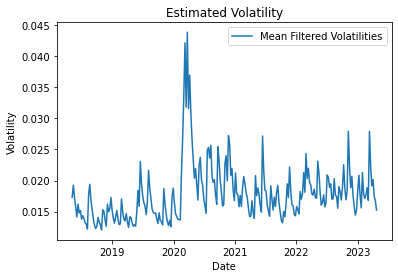

In [65]:
# Plot the results with volotility
import matplotlib.pyplot as plt
plt.plot(df_r.index, mean_filtered_volatilities, label="Mean Filtered Volatilities")
plt.title('Estimated Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

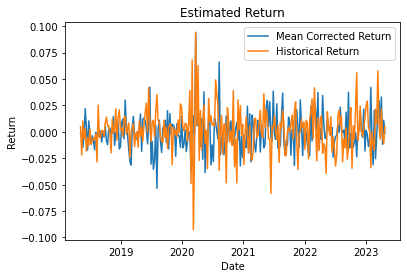

In [66]:
# Plot the results with return
plt.plot(df_r.index, mean_corrected_return, label="Mean Corrected Return")
plt.plot(df_r.index, df_r.GC.values, label="Historical Return")
plt.title('Estimated Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

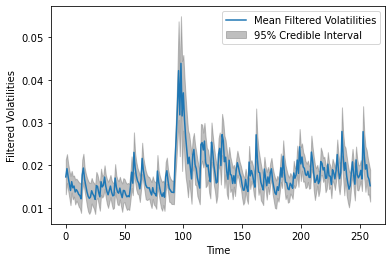

In [67]:
# Plot the mean filtered volatilities with CI
plt.plot(mean_filtered_volatilities, label="Mean Filtered Volatilities")

# Plot the 95% credible interval
plt.fill_between(range(len(mean_filtered_volatilities)),
                 mean_filtered_volatilities - 1.96 * std_filtered_volatilities,
                 mean_filtered_volatilities + 1.96 * std_filtered_volatilities,
                 color='gray', alpha=0.5, label="95% Credible Interval")

plt.xlabel("Time")
plt.ylabel("Filtered Volatilities")
plt.legend()
plt.show()


# Prediction

Predict Volatility

我们定义了一个名为 predict_volatility 的函数，它根据给定的参数 (mu, phi, sigma) 和初始波动率值对未来波动率进行迭代预测。我们使用最后一个时间步长的平均过滤波动率作为初始波动率，并对每个后验样本调用预测函数。最后，我们计算并绘制未来波动率的均值和 95% 置信区间。

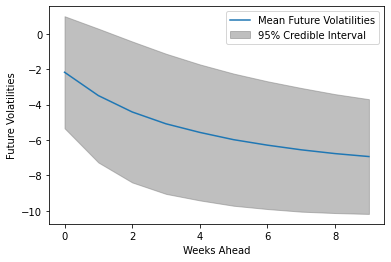

In [94]:
def predict_volatility(mu, phi, sigma, initial_volatility, steps=10):
    predicted_volatilities = np.zeros(steps)
    predicted_volatilities[0] = mu + phi * (initial_volatility - mu) + norm.rvs(scale=sigma)
    
    for t in range(1, steps):
        predicted_volatilities[t] = mu + phi * (predicted_volatilities[t - 1] - mu) + norm.rvs(scale=sigma)
    
    return predicted_volatilities

# Use the last value of mean_filtered_volatilities as initial_volatility
initial_volatility = mean_filtered_volatilities[-1]

# Predict future volatilities for each posterior sample
future_volatilities = np.zeros((10, len(mu_samples)))

for i, (mu, phi, sigma) in enumerate(zip(mu_samples, phi_samples, sigma_samples)):
    future_volatilities[:, i] = predict_volatility(mu, phi, sigma, initial_volatility)

# Calculate the mean and standard deviation of future volatilities
mean_future_volatilities = np.mean(future_volatilities, axis=1)
std_future_volatilities = np.std(future_volatilities, axis=1)

# Plot the future volatilities
plt.plot(mean_future_volatilities, label="Mean Future Volatilities")

# Plot the 95% credible interval
plt.fill_between(range(len(mean_future_volatilities)),
                 mean_future_volatilities - 1.96 * std_future_volatilities,
                 mean_future_volatilities + 1.96 * std_future_volatilities,
                 color='gray', alpha=0.5, label="95% Credible Interval")

plt.xlabel("Weeks Ahead")
plt.ylabel("Future Volatilities")
plt.legend()
plt.show()


In [82]:
future_volatilities_exp.shape

(10, 4000)

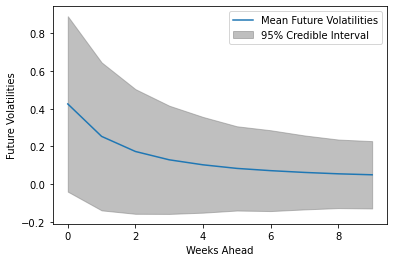

In [95]:
# Convert log-volatility to volatility
future_volatilities_exp = np.exp(future_volatilities / 2)

# Calculate the mean and standard deviation of future volatilities
mean_future_volatilities_exp = np.mean(future_volatilities_exp, axis=1)
std_future_volatilities_exp = np.std(future_volatilities_exp, axis=1)

# Plot the future volatilities - exp
plt.plot(mean_future_volatilities_exp, label="Mean Future Volatilities")

# Plot the 95% credible interval
plt.fill_between(range(len(mean_future_volatilities_exp)),
                 mean_future_volatilities_exp - 1.96 * std_future_volatilities_exp,
                 mean_future_volatilities_exp + 1.96 * std_future_volatilities_exp,
                 color='gray', alpha=0.5, label="95% Credible Interval")
plt.xlabel("Weeks Ahead")
plt.ylabel("Future Volatilities")
plt.legend()
plt.show()


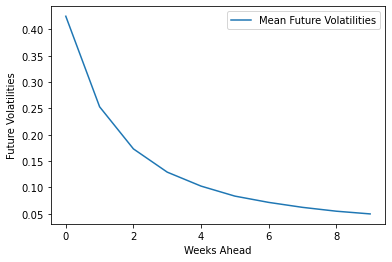

In [96]:
# Plot the mean future volatilities
plt.plot(mean_future_volatilities_exp, label="Mean Future Volatilities")
plt.xlabel("Weeks Ahead")
plt.ylabel("Future Volatilities")
plt.legend()
plt.show()

In [98]:
def generate_returns(volatilities):
    return norm.rvs(scale=volatilities)

# Generate future returns for each posterior sample
future_returns = generate_returns(mean_future_volatilities_exp)

In [88]:
np.std(future_returns, axis=0)

0.05217323259487726

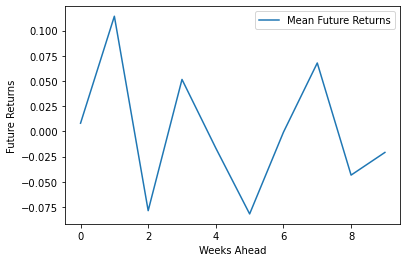

In [99]:
# Calculate the mean and standard deviation of future returns
mean_future_returns = np.mean(future_returns, axis=0)
std_future_returns = np.std(future_returns, axis=0)

# Plot the mean future returns
plt.plot(future_returns, label="Mean Future Returns")


plt.xlabel("Weeks Ahead")
plt.ylabel("Future Returns")
plt.legend()
plt.show()


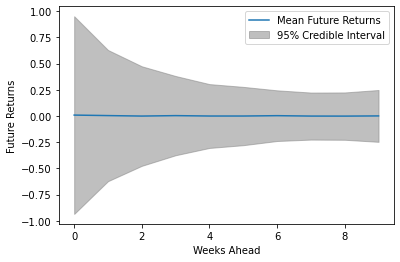

In [104]:
def generate_returns(volatilities):
    return norm.rvs(scale=volatilities)

# Generate future returns for each posterior sample
future_returns = np.zeros((10, len(mu_samples)))

for i in range(len(mu_samples)):
    future_returns[:, i] = generate_returns(future_volatilities_exp[:, i])

# Calculate the mean and standard deviation of future returns
mean_future_returns = np.mean(future_returns, axis=1)
std_future_returns = np.std(future_returns, axis=1)

# Plot the mean future returns
plt.plot(mean_future_returns, label="Mean Future Returns")

# Plot the 95% credible interval
plt.fill_between(range(len(mean_future_returns)),
                 mean_future_returns - 1.96 * std_future_returns,
                 mean_future_returns + 1.96 * std_future_returns,
                 color='gray', alpha=0.5, label="95% Credible Interval")

plt.xlabel("Weeks Ahead")
plt.ylabel("Future Returns")
plt.legend()
plt.show()


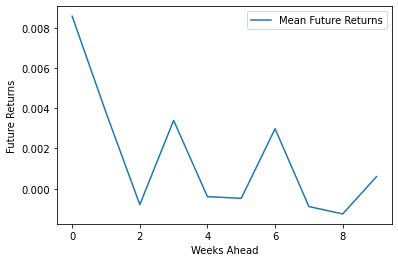

In [105]:
# Plot the mean future returns
plt.plot(mean_future_returns, label="Mean Future Returns")
plt.xlabel("Weeks Ahead")
plt.ylabel("Future Returns")
plt.legend()
plt.show()


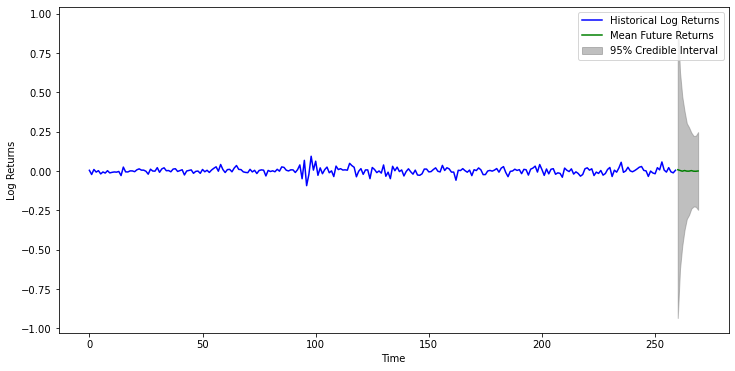

In [106]:
# Plot return
plt.figure(figsize=(12, 6))

# Plot historical log returns
historical_len = T
plt.plot(range(historical_len), df_r.GC.values, label="Historical Log Returns", color="blue")

# Plot the mean future returns
future_len = len(mean_future_returns)
plt.plot(range(historical_len, historical_len + future_len), mean_future_returns, label="Mean Future Returns", color="green")

# Plot the 95% credible interval
plt.fill_between(range(historical_len, historical_len + future_len),
                 mean_future_returns - 1.96 * std_future_returns,
                 mean_future_returns + 1.96 * std_future_returns,
                 color='gray', alpha=0.5, label="95% Credible Interval")

plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.legend()
plt.show()

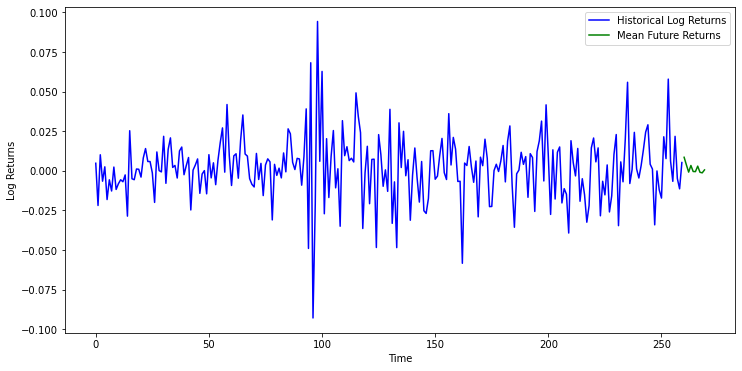

In [107]:
# Plot return
plt.figure(figsize=(12, 6))

# Plot historical log returns
historical_len = len(df_r.GC.values)
plt.plot(range(historical_len), df_r.GC.values, label="Historical Log Returns", color="blue")

# Plot the mean future returns
future_len = len(mean_future_returns)
plt.plot(range(historical_len, historical_len + future_len), mean_future_returns, label="Mean Future Returns", color="green")

# Plot the 95% credible interval

plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.legend()
plt.show()

using ARIMA

In [108]:
from statsmodels.tsa.arima.model import ARIMA

# 1. Use the last time step of filtered volatilities to predict future volatilities
last_volatility = mean_filtered_volatilities[-1]

# 2. Train an ARIMA model on historical return data
model = ARIMA(y, order=(1, 0, 0))
arima_model = model.fit()

# 3. Generate future return predictions
n_forecast = 10  # Number of time steps to forecast
forecasted_returns = arima_model.forecast(steps=n_forecast)

# Incorporate the predicted volatility
future_volatilities = np.ones(n_forecast) * last_volatility
forecasted_returns_with_volatility = forecasted_returns * np.exp(future_volatilities / 2)

print("Forecasted returns with predicted volatility:")
print(forecasted_returns_with_volatility)


Forecasted returns with predicted volatility:
[0.00141978 0.0018676  0.00181584 0.00182182 0.00182113 0.00182121
 0.0018212  0.0018212  0.0018212  0.0018212 ]


In [36]:

# Set the rolling window and forecast horizon
rolling_window = 10
n_forecast = 10

# Get the last 30 days of filtered volatilities
last_volatilities = mean_filtered_volatilities[-rolling_window:]

# Train an ARIMA model on the last 30 days of filtered volatilities
model = ARIMA(last_volatilities, order=(1, 0, 0))
arima_model = model.fit()

# Forecast the next 30 days of volatilities
forecasted_volatilities = arima_model.forecast(steps=n_forecast)

print("Forecasted volatilities for the next 30 days:")
print(forecasted_volatilities)


Forecasted volatilities for the next 30 days:
[-10.19935617 -10.20027291 -10.20023588 -10.20023737 -10.20023731
 -10.20023732 -10.20023732 -10.20023732 -10.20023732 -10.20023732
 -10.20023732 -10.20023732 -10.20023732 -10.20023732 -10.20023732
 -10.20023732 -10.20023732 -10.20023732 -10.20023732 -10.20023732
 -10.20023732 -10.20023732 -10.20023732 -10.20023732 -10.20023732
 -10.20023732 -10.20023732 -10.20023732 -10.20023732 -10.20023732]


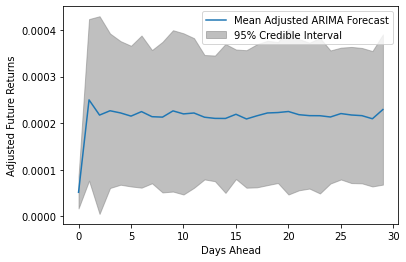

In [42]:
#### using ARIMA another method
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model to the historical return data
arima_model = ARIMA(y, order=(1, 0, 1))
arima_fit = arima_model.fit()

# Forecast future returns using the ARIMA model
arima_forecast = arima_fit.forecast(steps=10)

# Adjust the ARIMA forecast based on the future volatilities
future_volatility_ratios = np.exp((future_volatilities - mean_filtered_volatilities[-1]) / 2)
adjusted_arima_forecast = arima_forecast[:, np.newaxis] * future_volatility_ratios

# Calculate the mean and standard deviation of the adjusted ARIMA forecast
mean_adjusted_arima_forecast = np.mean(adjusted_arima_forecast, axis=1)
std_adjusted_arima_forecast = np.std(adjusted_arima_forecast, axis=1)

# Plot the mean adjusted ARIMA forecast
plt.plot(mean_adjusted_arima_forecast, label="Mean Adjusted ARIMA Forecast")

# Plot the 95% credible interval
plt.fill_between(range(len(mean_adjusted_arima_forecast)),
                 mean_adjusted_arima_forecast - 1.96 * std_adjusted_arima_forecast,
                 mean_adjusted_arima_forecast + 1.96 * std_adjusted_arima_forecast,
                 color='gray', alpha=0.5, label="95% Credible Interval")

plt.xlabel("Days Ahead")
plt.ylabel("Adjusted Future Returns")
plt.legend()
plt.show()
